# Why is Pooling Required?
Pooling Layer is a non-trainable layer that complements the Convolutional Layer. Using a Pooling Layer, we can achieve **translational invariance** (refer the image below) i.e., it is invariant to small amount of shifting, scaling, rotation, etc in the _spatial dimension._ By varying the hyperparameters of the pooling layer we can adjust the amount of invariance.

![](assets/poling_invariance.png)

The feature map is fed as input to the Pooling Layer where each value is considered a **random variable.** Thus the Probability Density Function/Probability Mass Function of these random variables have some parameters associated with them. Thus instead of using the random variables (aka the feature map), if we were to use just the **parameters, we can achieve data reduction while not loosing much information.** This parameter which is **estimated from our samples is called a Summary Statistics.** For example, consider a Uniform Distribution, using just the $\text{Max}_i(X_i)$ is enough the represent the whole PDF and hence the whole feature map. But choosing such a statistics, in this case $\text{Max}_i(X_i)$ has a long mathematical explanation, which is summarized below.

### Choosing the best Summary Statistics
Given the random variables (aka feature map), the true underlying parameter of the PDF/PMF can be *estimated (using our samples)* using a huge variety of statistics, these are called as **Summary Statistic.** But we want the ones which captures all the information about the parameter *contained in the sample*, this is called as a **Sufficient Statistics.**  But we also want the statistics to achieve as much data reduction as possible without loss of information about the parameter(suff stat), this is called as a **Minimal Sufficient Statistics.** This Minimal Sufficient Statistics $T(X)$ is a function of any of the other Sufficient Statistics, thus any sufficient statistic $T'(X)$ can be reduced to $T(X)$, which means $T(X)$ provides more data reduction without losing much information. Also **any one-to-one mapping of MSS is also a MSS,** and some are helpful than the other.

The best one-to-one mapping of the MSS is the one which is also a Maximum Likelihood Estimator (MLE), these provide unbiasedness and minimum variance. Such a one-to-one mapping of MSS is called a **Complete Minimal Sufficient Statistics.** There is also another statistic called **Minimum Variance Unbiased Estimator (MVUE)** which is unique and efficient, thus making it really useful for Pooling. The good thing is, a **one-to-one 
mapping of Complete Minimal Sufficient Statistics (which is a MLE) is a MVUE.** And if such a statistics is found, it has properties like efficiency, unbiasedness and minimum variance. Finally, it can be shown that the MaxPooling and AveragePooling are MLEs.

### Multiple Pooling
A Complete Minimal Sufficient Statistics(CMSS) only captures the information that are related to the parameter. But there are still other information that remaining in the sample that is independent of the parameter. For example the range, standard deviation  of the samples etc. Such statistics are called **Ancillary Statistics.** These provide information that are **complementary** to CMSS based MLE statistics for Pooling. This is where the concept of Multiple Pooling comes from and in this Notebook, I have implemented a CNN with **MaxPooling (MLE) which is complemented by Sample Range (Ancillary Statistics).** 

In [1]:
import os
from typing import (List, Tuple)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers.experimental import preprocessing
from utils.plotting import HistoryPlotter
from utils.generate_masked_faces import (process_face, process_mask, apply_mask)
import mediapipe as mp
import cv2

SEED = 42
BATCH_SIZE = 128
IMAGE_SIZE = [154,154]
EPOCHS = 30
LEARNING_RATE=0.001
DATASET_PATH = os.path.expanduser("~/Downloads/datasets/MaskedFaces")
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(SEED)

img_size = IMAGE_SIZE.copy()
img_size.append(3)
IMAGE_SIZE_3 = tuple(img_size)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset Generation
For the problem and dataset, I chose something that is practical and relevant to recent times. I wanted to do a classify if a person is wearing a mask or not. To tackle this, first I went with a dataset from [kaggle](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset), but the dataset had very few actual images of people with masks, most of the images in the dataset were augmented. Then I found this paper, [MaskedFace-Net – A dataset of correctly/incorrectly masked face images in the context of COVID-19](https://www.sciencedirect.com/science/article/pii/S2352648320300362) which talks about how to overlay masks onto people's faces to create a Masked Face Dataset. I took some of its ideas and implemented my own [Dataset Generator](https://github.com/RolandSherwin/MultiplePooling-and-AutoencoderClassifierHybrid/blob/main/masked-face-generator.ipynb). The prototype of its working is given below.

The final dataset contains 12,000 images from the Kaggle Dataset and 25,000 (15,000 masked, 10,000 unmasked) Generated images, for a total of 37,000 images.

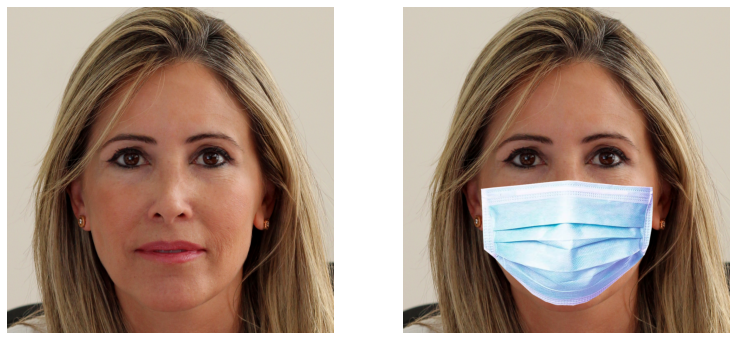

In [17]:
# Use Mediapipe's prebuilt Face Mesh Model to get the landmarks (just 6 out of 468) on the given face
mesh_model = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)
face_img = cv2.imread('./assets/00059.png')
f_height, f_width = face_img.shape[:2]
face_landmarks = mesh_model.process(face_img)
face_annotation = process_face(face_landmarks, f_height, f_width)[0]

# Get the mask and its 6 annotations (corresponds to the 6 annotations on the face)
mask_img, mask_annotation = process_mask('./assets/mask_blue.png', './assets/mask_blue_6.csv')

# Now the mask is warped such that both the face_annotation and mask_annotation match
masked_image = apply_mask(mask_img, mask_annotation, face_img, face_annotation)

# View the result
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
ax1.set_axis_off()
ax2.set_axis_off()
ax1.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB));
ax2.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB));

In [2]:
train_ds = keras.preprocessing.image_dataset_from_directory(DATASET_PATH,
                                                            validation_split=0.1,
                                                            subset="training",
                                                            seed=SEED,
                                                            image_size=IMAGE_SIZE,
                                                            batch_size=BATCH_SIZE, # def = 32
                                                            )
validation_ds = keras.preprocessing.image_dataset_from_directory(DATASET_PATH,
                                                            validation_split=0.1,
                                                            subset="validation",
                                                            seed=SEED,
                                                            image_size=IMAGE_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            )

# take 5 batches for test_ds, rest for validation_ds
test_ds = validation_ds.take(5).cache().prefetch(AUTOTUNE)
validation_ds = validation_ds.skip(5)

Found 37465 files belonging to 2 classes.
Using 33719 files for training.
Found 37465 files belonging to 2 classes.
Using 3746 files for validation.


# Augmentation
Adding a simple augmentation to flip the image vertically and horizontally. This forces the model to be more tolerant to these effect and hence reducing the model's complexity, i.e., it acts a **Regularizer.** 

In [3]:
augmentations = keras.Sequential([
	preprocessing.Rescaling(scale=1.0 / 255),
	preprocessing.RandomFlip("horizontal_and_vertical", seed=SEED),
])
train_ds = train_ds.map(lambda x,y: (augmentations(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
validation_ds = validation_ds.map(lambda x,y: (augmentations(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

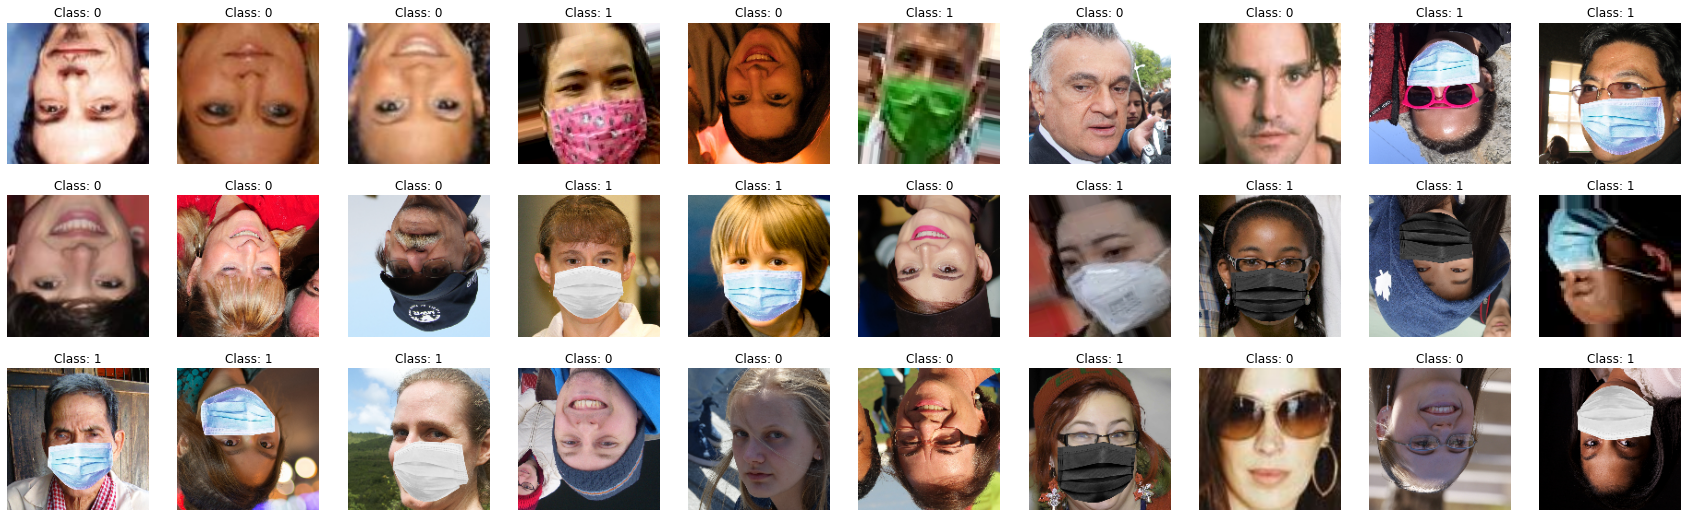

In [4]:
def plot_image(tfds_take, model=None, row_col: List[int]=[3,6], scaled: bool = True):
    """Plot image in a grid given a single batch of a tfds

    Args:
        tfds_take (tfds.take()): A single batch of tfds i.e., tfds.take(1)
        model (tf model, optional): Trained tensorflow mode, to predict the. Defaults to None.
        row_col (List[int], optional): Grid size. Defaults to [3,6].
        scaled (bool): If the images are scaled to [0,1] rescale it back to [0,255]
    """
    fig = plt.figure(figsize=(row_col[1]*3, row_col[0]*3))
    
    for batch_img, batch_label in tfds_take:
        if model is not None:
            batch_pred = model.predict(batch_img)
            batch_pred = np.round(batch_pred, 2)

        for i in range(1, row_col[0]*row_col[1]+1): 
            ax = fig.add_subplot(row_col[0], row_col[1], i)
            if scaled:
                ax.imshow((batch_img[i].numpy()*255).astype("uint8"))
            else:
                ax.imshow(batch_img[i].numpy().astype("uint8"))
            ax.set_axis_off()

            if model is None:
                plt.title("Class: " + str(batch_label[i].numpy()))
            else:
                plt.title("True/Pred: " + str(batch_label[i].numpy()) + "/" + str(batch_pred[i][0]))
        # Process 1 batch alone if more is passed.
        break

plot_image(train_ds.take(1), row_col=[3,10])

# Baseline Model
First a simple Baseline Model with a Sequential CNN architecture is constructed. It is to be noted that the **Pooling is applied after the activation function.** As mentioned in the book, [Understanding Deep Learning](https://www.understandingdeeplearning.com/), the nonlinear activation will distort the original distribution. Thus this is not the optimal way.

In [5]:
baseline_model = keras.models.Sequential([
    # layer 1
    keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=IMAGE_SIZE_3, activation='relu'),
    keras.layers.MaxPool2D(pool_size=6, strides=3),
    # layer 2
    keras.layers.Conv2D(filters=64, kernel_size=4, activation='relu'),
    keras.layers.MaxPool2D(pool_size=4, strides=3),
    # layer 3
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    # layer 4
    keras.layers.Dense(units=64, activation='relu'),
    # layer 5
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [6]:
def n_weights(model) -> Tuple[int,int]:
    """Return the number of total weights and trainable weights
    
    Args:
        model: Tensorflow model
    Returns:
        Tuple[int, int]: Returns the total_weights and trainable_weights
    """
    n_total = 0
    n_train = 0
    for weight in model.weights:
        n_total += weights_from_shape(weight.shape)
        
    for weight in model.trainable_weights:
        n_train += weights_from_shape(weight.shape)
    
    return n_total, n_train

def weights_from_shape(shape) -> int:
    """Compute the total number of weights given the shape of the tensor.
    """
    weights = 1
    for dim in shape:
        weights *= int(dim)
    return weights

In [7]:
total_weights, train_weights = n_weights(baseline_model)
print(f"Total weights/parameters: {total_weights:,}\nTrainable weights/parameters: {train_weights:,}")

Total weights/parameters: 121,185
Trainable weights/parameters: 121,185


In [8]:
baseline_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)
baseline_history = baseline_model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)

Epoch 1/30
264/264 [==============================] - 461s 2s/step - loss: 0.7413 - binary_accuracy: 0.5237 - precision: 0.5434 - recall: 0.8185 - val_loss: 0.7292 - val_binary_accuracy: 0.5576 - val_precision: 0.5576 - val_recall: 1.0000
Epoch 2/30
264/264 [==============================] - 3s 12ms/step - loss: 0.7250 - binary_accuracy: 0.5481 - precision: 0.5481 - recall: 1.0000 - val_loss: 0.7172 - val_binary_accuracy: 0.5576 - val_precision: 0.5576 - val_recall: 1.0000
Epoch 3/30
264/264 [==============================] - 3s 11ms/step - loss: 0.7123 - binary_accuracy: 0.5487 - precision: 0.5484 - recall: 0.9998 - val_loss: 0.7024 - val_binary_accuracy: 0.5634 - val_precision: 0.5610 - val_recall: 0.9983
Epoch 4/30
264/264 [==============================] - 3s 12ms/step - loss: 0.6931 - binary_accuracy: 0.5851 - precision: 0.5697 - recall: 0.9928 - val_loss: 0.6786 - val_binary_accuracy: 0.6478 - val_precision: 0.6157 - val_recall: 0.9804
Epoch 5/30
264/264 [========================

5/5 [==============================] - 0s 9ms/step - loss: 20.7748 - binary_accuracy: 0.9531 - precision: 0.9675 - recall: 0.9451


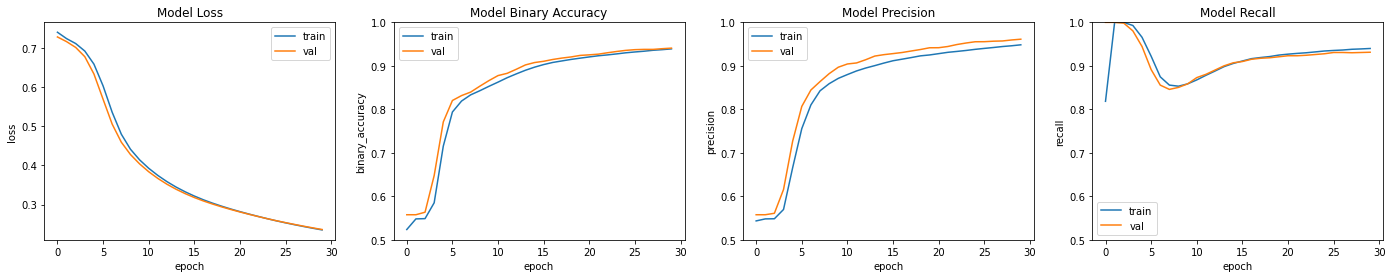

In [18]:
baseline_model.evaluate(test_ds)
np.save("./models/baseline_history.npy", baseline_history.history)
# baseline_history = np.load("./models/baseline_history.npy", allow_pickle='TRUE').item()
baseline_plot = HistoryPlotter(history=baseline_history.history)
baseline_plot.all(row_col=[1,0])

# Optimal Pooling Location
In this second model, the **Non-Linear activation is applied after the Pooling Layer.** This is the optimal way to apply pooling since, distortion in the feature map distribution due to non-linear activations is **detrimental to pooling** because most of the information is lost or masked.

Thus instead of applying Convolution -> Activation -> Pooling as in the baseline model, here we apply Convolution -> Pooling -> Activation to preserve the feature map's distribution while not impacting the network's nonlinearity.

In [9]:
optimal_pooling = keras.models.Sequential([
    # layer 1
    keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=IMAGE_SIZE_3),
    keras.layers.MaxPool2D(pool_size=6, strides=3),
    keras.layers.Activation('relu'),
    # layer 2
    keras.layers.Conv2D(filters=64, kernel_size=4),
    keras.layers.MaxPool2D(pool_size=4, strides=3),
    keras.layers.Activation('relu'),
    # layer 3
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    # layer 4
    keras.layers.Dense(units=64, activation='relu'),
    # layer 5
    keras.layers.Dense(units=1, activation='sigmoid')
])
total_weights, train_weights = n_weights(optimal_pooling)
print(f"Total weights/parameters: {total_weights:,}\nTrainable weights/parameters: {train_weights:,}")

Total weights/parameters: 121,185
Trainable weights/parameters: 121,185


In [10]:
optimal_pooling.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)
optimal_pooling_history = optimal_pooling.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)

Epoch 1/30
264/264 [==============================] - 4s 12ms/step - loss: 0.7321 - binary_accuracy: 0.5481 - precision_1: 0.5481 - recall_1: 1.0000 - val_loss: 0.7222 - val_binary_accuracy: 0.5576 - val_precision_1: 0.5576 - val_recall_1: 1.0000
Epoch 2/30
264/264 [==============================] - 3s 11ms/step - loss: 0.7168 - binary_accuracy: 0.5479 - precision_1: 0.5480 - recall_1: 0.9992 - val_loss: 0.7056 - val_binary_accuracy: 0.5602 - val_precision_1: 0.5591 - val_recall_1: 0.9994
Epoch 3/30
264/264 [==============================] - 3s 11ms/step - loss: 0.6974 - binary_accuracy: 0.5667 - precision_1: 0.5587 - recall_1: 0.9965 - val_loss: 0.6828 - val_binary_accuracy: 0.6059 - val_precision_1: 0.5868 - val_recall_1: 0.9913
Epoch 4/30
264/264 [==============================] - 3s 11ms/step - loss: 0.6697 - binary_accuracy: 0.6474 - precision_1: 0.6108 - recall_1: 0.9826 - val_loss: 0.6498 - val_binary_accuracy: 0.7006 - val_precision_1: 0.6565 - val_recall_1: 0.9711
Epoch 5/30
2

5/5 [==============================] - 0s 11ms/step - loss: 19.6222 - binary_accuracy: 0.9500 - precision_1: 0.9673 - recall_1: 0.9393


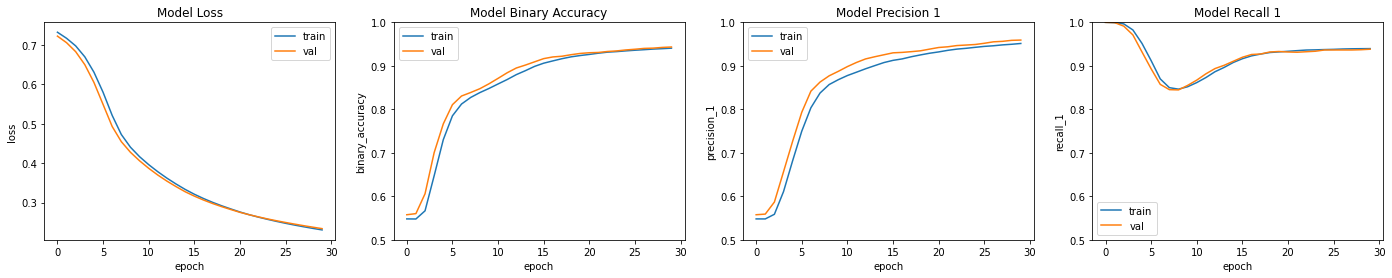

In [17]:
optimal_pooling.evaluate(test_ds)
np.save("./models/optimal_pooling_history.npy", optimal_pooling_history.history)
# baseline_history = np.load("./models/optimal_pooling_history.npy", allow_pickle='TRUE').item()
optimal_pooling_plot = HistoryPlotter(history=optimal_pooling_history.history)
optimal_pooling_plot.all(row_col=[1,0])

# Multiple Pooling
Here we apply both **Max Pooling** (Complete Minimal Sufficient Statistics) and **Range Pooling** (Ancillary Statistics). Also the activations are applied after the pooling layers. 

The Range Pooling is calculated by taking the difference between the MaxPooling and MinPooling of the input feature map. To achieve Multiple Pooling, we can **concatenate the MaxPooling and RangePooling.** 

### Implementation Details
1. Lambda Layers are used instead of the tensor operations since they lead to layer being not connected to each other.
2. Without the use of Parameter Norm Penalty (L2 regularizer) in the first Conv2D layer, the model's loss grows exponentially. This might be caused due to the Subtraction operation while calculating RangePooling which might have lead to negative values.
4. The number of Conv Filters in Layer 2 was reduced to 32 (instead of 64 in the previous models). This is because we concatenated MaxPooling and RangePooling and hence the number of channels in that layer has doubled. Hence to make the number of weights/parameters same for all the models, the # of filters were reduced.

Total weights/parameters: 121,153
Trainable weights/parameters: 121,153


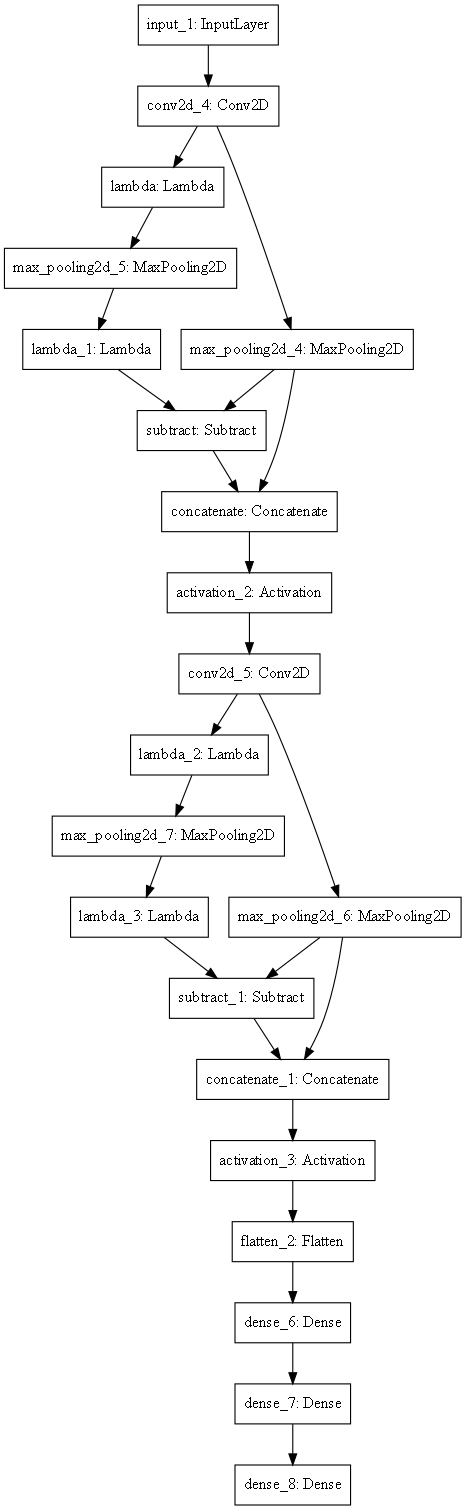

In [12]:
def get_multi_pooling_model():
    inputs = keras.layers.Input(shape=IMAGE_SIZE_3)
    # Error while calculating the l1_range if this layer is not regularized.
    l1 = keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=IMAGE_SIZE_3)(inputs)
    
    l1_max = keras.layers.MaxPool2D(pool_size=6, strides=3)(l1)
    # 1. negative of feature map
    l1_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l1) 
    # 2. apply maxpool to get min statistics
    l1_min = keras.layers.MaxPool2D(pool_size=6, strides=3)(l1_min)
    # 3. Revert to original after getting min statistics
    l1_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l1_min)
    # 4. get range statistic max - min
    l1_range = keras.layers.subtract([l1_max, l1_min])
    # 5. Concatenate to get multiple pooling
    l1_multi_pool = keras.layers.Concatenate()([l1_max, l1_range]) # num of channels = 2x baseline = 64
    l1_multi_pool = keras.layers.Activation('relu')(l1_multi_pool) 

    l2 = keras.layers.Conv2D(filters=32, kernel_size=4)(l1_multi_pool) # reduce filter to 32 to make it similar to baseline
    
    l2_max = keras.layers.MaxPool2D(pool_size=4, strides=3)(l2) 
    l2_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l2)
    l2_min = keras.layers.MaxPool2D(pool_size=4, strides=3)(l2_min)
    l2_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l2_min)
    l2_range = tf.keras.layers.subtract([l2_max, l2_min])
    l2_multi_pool = keras.layers.Concatenate()([l2_max, l2_range])
    l2_multi_pool = keras.layers.Activation('relu')(l2_multi_pool)

    l3 = keras.layers.Flatten()(l2_multi_pool)
    l3 = keras.layers.Dense(units=128, activation='relu')(l3)
    l4 = keras.layers.Dense(units=64, activation='relu')(l3)
    l5 = keras.layers.Dense(units=1, activation='sigmoid')(l4)

    model = keras.models.Model(inputs=inputs, outputs=l5)
    return model

multi_pooling = get_multi_pooling_model()

total_weights, train_weights = n_weights(multi_pooling)
print(f"Total weights/parameters: {total_weights:,}\nTrainable weights/parameters: {train_weights:,}")
keras.utils.plot_model(multi_pooling, show_shapes=False, dpi=80)

## Custom Layer using Sub Classing
A custom layer was created that that combines MaxPool2D and RangePooling.

Total weights/parameters: 121153
Trainable weights/parameters: 121153


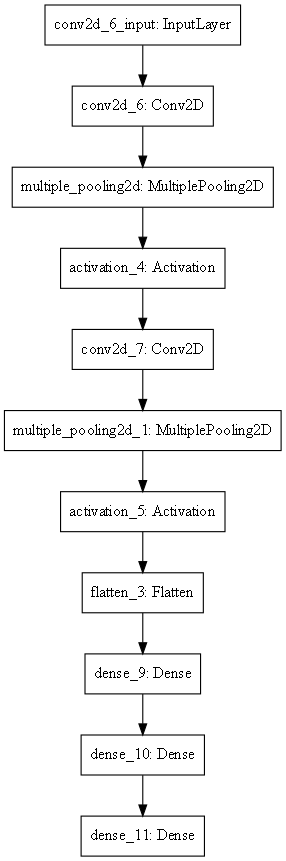

In [13]:
class MultiplePooling2D(keras.layers.Layer):
    def __init__(self, pool_size, strides, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides
        self.max_pool = keras.layers.MaxPool2D(pool_size=self.pool_size, strides=self.strides)
        self.negative = keras.layers.Lambda(lambda x: tf.math.negative(x))
        self.concat = keras.layers.Concatenate()
    
    def call(self, inputs):
        _max = self.max_pool(inputs)
        # 1. negative of feature map
        _min = self.negative(inputs)
        # 2. apply max_pool to get min stat
        _min = self.max_pool(_min)
        # 3. revert to original after getting min stat
        _min = self.negative(_min)
        # 4. get range stat, max-min
        _range = keras.layers.subtract([_max, _min])
        # 5. concatenate max, min to get the multiple pooling
        _multi = self.concat([_max, _range]) 
        return _multi

multi_pooling_1 = keras.models.Sequential([
    # layer 1
    keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=IMAGE_SIZE_3),
    MultiplePooling2D(pool_size=6, strides=3),
    keras.layers.Activation('relu'),
    # layer 2
    keras.layers.Conv2D(filters=32, kernel_size=4),
    MultiplePooling2D(pool_size=4, strides=3),
    keras.layers.Activation('relu'),
    # layer 3
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    # layer 4
    keras.layers.Dense(units=64, activation='relu'),
    # layer 5
    keras.layers.Dense(units=1, activation='sigmoid')
])
total_weights, train_weights = n_weights(multi_pooling_1)
print(f"Total weights/parameters: {total_weights}\nTrainable weights/parameters: {train_weights}")

keras.utils.plot_model(multi_pooling_1, show_shapes=False, dpi=80)

In [14]:
multi_pooling_1.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)
multi_pooling_history = multi_pooling_1.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)

Epoch 1/30
264/264 [==============================] - 5s 14ms/step - loss: 0.7045 - binary_accuracy: 0.5490 - precision_2: 0.5486 - recall_2: 0.9990 - val_loss: 0.6835 - val_binary_accuracy: 0.5695 - val_precision_2: 0.5644 - val_recall_2: 0.9988
Epoch 2/30
264/264 [==============================] - 3s 13ms/step - loss: 0.6637 - binary_accuracy: 0.6203 - precision_2: 0.5918 - recall_2: 0.9904 - val_loss: 0.6312 - val_binary_accuracy: 0.7279 - val_precision_2: 0.6772 - val_recall_2: 0.9786
Epoch 3/30
264/264 [==============================] - 3s 13ms/step - loss: 0.6005 - binary_accuracy: 0.7826 - precision_2: 0.7343 - recall_2: 0.9455 - val_loss: 0.5570 - val_binary_accuracy: 0.8387 - val_precision_2: 0.8139 - val_recall_2: 0.9215
Epoch 4/30
264/264 [==============================] - 3s 13ms/step - loss: 0.5212 - binary_accuracy: 0.8535 - precision_2: 0.8446 - recall_2: 0.8978 - val_loss: 0.4743 - val_binary_accuracy: 0.8683 - val_precision_2: 0.8791 - val_recall_2: 0.8857
Epoch 5/30
2

5/5 [==============================] - 21s 2s/step - loss: 10.2432 - binary_accuracy: 0.9563 - precision_2: 0.9595 - recall_2: 0.9595


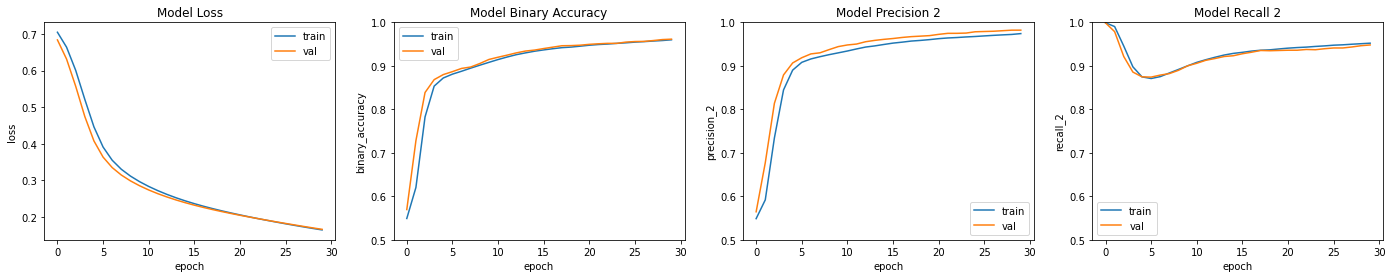

In [15]:
multi_pooling_1.evaluate(test_ds)
np.save("./models/multi_pooling_history.npy", multi_pooling_history.history)
# multi_pooling_history = np.load("./models/multi_pooling_history.npy", allow_pickle='TRUE').item()
multi_pooling_plot = HistoryPlotter(history=multi_pooling_history.history)
multi_pooling_plot.all(row_col=[1,0])

## Model's Prediction

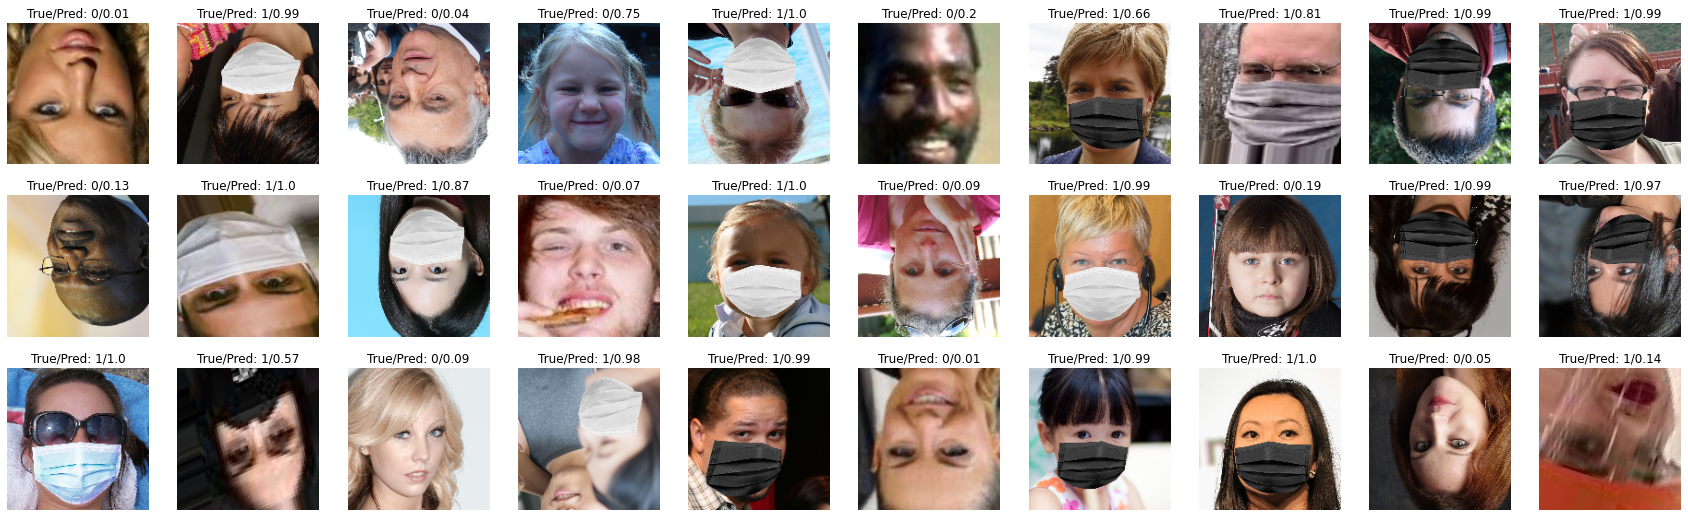

In [16]:
plot_image(train_ds.take(1), model=multi_pooling_1, row_col=[3,10])

# Conclusion
With each model having the same number of trainable parameters (121,153) and same hyperparameters like the Optimization Algorithm, Learning Rate and Epochs, the final performance on the Test Sets are given below.

| Model                          | Loss  | Accuracy(%) | Precision(%) | Recall(%) |
| ------------------------------ | ----- | ----------- | ------------ | --------- |
| Baseline Model                 | 20.77 | 95.35       | 96.75        | 94.51     |
| Optimal Pooling Location Model | 19.62 | 95.00       | 96.73        | 93.39     |
| Multiple Pooling Model         | 10.24 | 95.63       | 95.95        | 95.95     | 

As we can see clearly that the overall Loss on the Test Set were reduced by 5.5% (from 20.77 to 19.62) when the non-liner Activations are applied after the Pooling Layer. And the Loss were reduced by 50% (from 20.77 to 10.64) when Multiple Pooling was applied. But due to the simplicity of the problem, the performance metrics were almost the same for all three models. To reach a much clear conclusion the models must be applied on much wider range of problems and datasets. But still it is evident from this single experiment that MultiplePooling is really efficient in 